In [1]:
import polars as pl
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import logging
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(tf.__version__)

2024-06-15 16:24:17.744338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 16:24:17.810871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 16:24:18.821006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq, build_sequences_seq_iterator, N_CATEGORY, N_SENTIMENT_LABEL, N_SUBCATEGORY, N_TOPICS, N_HOUR_GROUP, N_WEEKDAY
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

history = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq = build_history_seq(history, articles)

Memory usage of dataframe is 35.03 MB
Memory usage after optimization is: 34.44 MB
Decreased by 1.7%


In [3]:
import numpy as np
import tensorflow as tf
window = 20

# Define the output signature for the tuple of dictionaries
output_signature = (
    {
        "input_topics": tf.TensorSpec(shape=(window,N_TOPICS+1), dtype=tf.int32),
        "input_category": tf.TensorSpec(shape=(window,1), dtype=tf.int32),
        'input_subcategory': tf.TensorSpec(shape=(window, N_SUBCATEGORY+1), dtype=tf.int32), # subcategory
        'input_weekday': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # weekday
        'input_hour_group': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # hour_group
        'input_sentiment_label': tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # sentiment_label
        'input_numerical': tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # (premium, read_time, scroll_percentage)
    },
    {
        "output_topics": tf.TensorSpec(shape=(N_TOPICS + 1,), dtype=tf.int32),
        "output_category": tf.TensorSpec(shape=(N_CATEGORY + 1, ), dtype=tf.int32),
        'output_subcategory': tf.TensorSpec(shape=(N_SUBCATEGORY + 1,), dtype=tf.int32), # subcategory
        'output_sentiment_label': tf.TensorSpec(shape=(N_SENTIMENT_LABEL + 1,), dtype=tf.int32), # sentiment_label
    }
)

# Create the dataset from the generator
dataset = tf.data.Dataset.from_generator(
     lambda: build_sequences_seq_iterator(history_seq, window=20, stride=5),
     output_signature=output_signature
)


In [4]:
from polimi.utils.tf_models import TemporalHistorySequenceModel, TemporalHistoryClassificationModel
from polimi.utils._polars import reduce_polars_df_memory_size

model = TemporalHistorySequenceModel(
    seq_embedding_dims={
        # adding, for the moment, one dim more to cover missings in non one-hot vectors
        'input_topics': (N_TOPICS + 1, 10, True),
        'input_subcategory': (N_SUBCATEGORY + 1, 10, True),
        'input_category': (N_CATEGORY + 1, 10, False),
        'input_weekday': (N_WEEKDAY, 3, False),
        'input_hour_group': (N_HOUR_GROUP, 3, False),
        'input_sentiment_label': (N_SENTIMENT_LABEL + 1, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    n_recurrent_layers=1,
    recurrent_embedding_dim=64,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
)

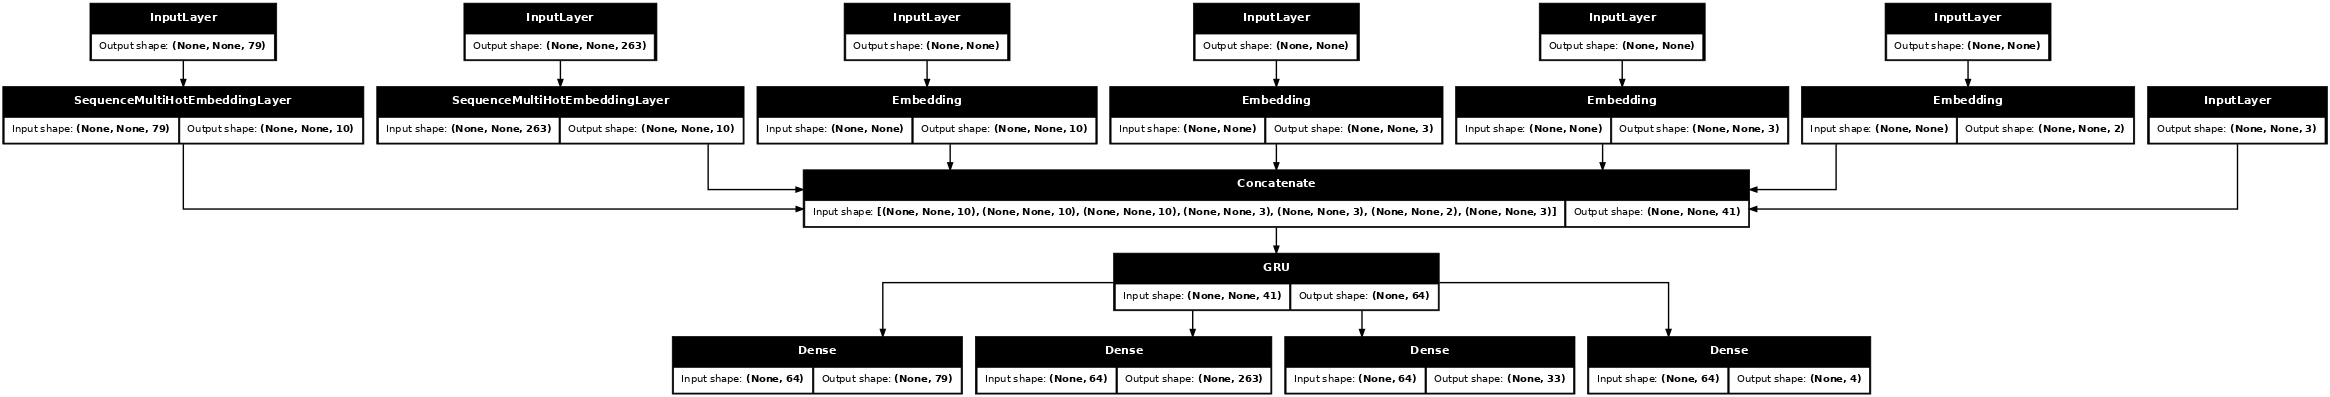

In [5]:
model._build()
model.plot()

In [6]:
dataset = dataset.batch(64).shuffle(buffer_size=1024)

In [7]:
model.fit(
    train_dataset=dataset,
    batch_size=64,
    epochs=10,
    # target for (topics, subcategory, category)
    loss={
        'output_topics': tfk.losses.BinaryCrossentropy(), 
        'output_subcategory': tfk.losses.BinaryCrossentropy(), 
        'output_category': tfk.losses.CategoricalCrossentropy(),
        'output_sentiment_label': tfk.losses.CategoricalCrossentropy(),
    },
    loss_weights={
        'output_topics': 0.5, 
        'output_subcategory': 0.1, 
        'output_category': 0.3,
        'output_sentiment_label': 0.1,
    },
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4)
)

Epoch 1/10


2024-06-15 16:24:37.102278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 205 of 1024
2024-06-15 16:24:47.125528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 422 of 1024
2024-06-15 16:25:07.110288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 848 of 1024


      3/Unknown 53s 33ms/step - loss: 5.9080

2024-06-15 16:25:15.483540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  37744/Unknown 1959s 51ms/step - loss: 4.2187

KeyboardInterrupt: 

In [2]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

history = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

columns = [
    'device_type', 'read_time', 'scroll_percentage', 'is_sso_user', 'gender', 'age', 'is_subscriber', 'postcode',
    'trendiness_score_1d', 'trendiness_score_3d', 'weekday', 'hour', 'trendiness_score_1d/3d', 
    'normalized_trendiness_score_overall', 'premium', 'category', 'sentiment_score', 'sentiment_label', 
    'num_images', 'title_len', 'subtitle_len', 'body_len', 'num_topics', 'total_pageviews', 'total_inviews',
    'total_read_time', 'total_pageviews/inviews', 'article_type', 'article_delay_days', 'article_delay_hours', 
    'Entity_LOC_Present', 'Entity_PROD_Present', 'Entity_ORG_Present', 'Entity_MISC_Present',
    'Entity_EVENT_Present', 'Entity_PER_Present', 'mean_user_trendiness_score', 'mean_topics_trendiness_score',
    'is_inside_window_0', 'is_inside_window_1', 'is_inside_window_2', 'is_inside_window_3', 'window_category_score',
    'window_topics_score', 'trendiness_score_category', 'endorsement_10h', 'normalized_endorsement_10h',
    'endorsement_10h_diff_rolling', 'endorsement_macd', 'endorsement_quantile_norm_10h',
    'normalized_endorsement_10h_rolling_max_ratio', 'endorsement_20h_articleuser', 'normalized_endorsement_articleuser_20h',
    'endorsement_20h_articleuser_diff_rolling', 'endorsement_articleuser_macd', 'endorsement_articleuser_quantile_norm_20h',
    'normalized_endorsement_articleuser_20h_rolling_max_ratio', 'last_session_duration', 'mean_prev_sessions_duration',
    'last_session_time_hour_diff', 'is_new_article', 'is_already_seen_article', 'yesterday_category_daily_pct',
    'target', 'user_id'
]
behaviors = pl.scan_parquet('/home/ubuntu/dset_complete/subsample/train_ds.parquet').select(columns).collect()

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'postcode', 'weekday', 'premium', 'category',
                       'sentiment_label', 'Entity_LOC_Present', 'Entity_PROD_Present', 'Entity_ORG_Present', 'Entity_MISC_Present',
                       'Entity_EVENT_Present', 'Entity_PER_Present']
numerical_columns = [c for c in columns if c not in categorical_columns + ['target', 'user_id', 'impression_id', 'article']]

behaviors_pandas = behaviors.to_pandas()

xformer = PowerTransformer()
behaviors_pandas[numerical_columns] = xformer.fit_transform(behaviors_pandas[numerical_columns]).astype(np.float32)

encoder = OrdinalEncoder()
behaviors_pandas[categorical_columns] = encoder.fit_transform(behaviors_pandas[categorical_columns]).astype(np.int16)
behaviors = behaviors.select(['target', 'user_id']).hstack(pl.from_pandas(behaviors_pandas))

history_seq = build_history_seq(history, articles)

history_seq.head(3)

ValueError: could not convert string to float: 'article_default'

In [ ]:
from polimi.utils.tf_models.utils.build_sequences import build_sequences_cls_iterator
from tensorflow.data import Dataset

window = 20
training_dataset = Dataset.from_generator(
    lambda : build_sequences_cls_iterator(history_seq, behaviors, window=window),
    output_signature=(
        (
            tf.TensorSpec(shape=(len(numerical_columns),), dtype=tf.float32), # behaviors numerical columns
            *[tf.TensorSpec(shape=(1,), dtype=tf.int16) for _ in categorical_columns], # behaviors categorical columns
            tf.TensorSpec(shape=(window, 78), dtype=tf.int32), # topics
            tf.TensorSpec(shape=(window, 174), dtype=tf.int32), # subcategory
            tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # category
            tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # weekday
            tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # hour_group
            tf.TensorSpec(shape=(window, 1), dtype=tf.int32), # sentiment_label
            tf.TensorSpec(shape=(window, 3), dtype=tf.float32), # (premium, read_time, scroll_percentage)
        ),
        tf.TensorSpec(shape=(1,), dtype=tf.float32), # target
    )
)

In [ ]:
from polimi.utils.tf_models import TemporalHistorySequenceModel, TemporalHistoryClassificationModel

model = TemporalHistoryClassificationModel(
    categorical_features=categorical_columns,
    numerical_features=numerical_columns,
    categorical_transform=None,
    numerical_transform=None,
    seq_embedding_dims={
        # adding, for the moment, one dim more to cover missings in non one-hot vectors
        'topics': (78, 10, True),
        'subcategory': (174, 10, True),
        'category': (26, 10, False),
        'weekday': (8, 3, False),
        'hour_group': (7, 3, False),
        'sentiment_label': (4, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    n_recurrent_layers=1,
    recurrent_embedding_dim=64,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
    dense_n_layers=1,
    dense_start_units=128,
)